In [2]:
!pip install rembg==2.0.56

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00


# Imports

In [3]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

# Constants

In [4]:
BASE_PATH = '/kaggle/input/key-images/'

# Model

In [5]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)

# Helper Functions

In [6]:
def extract_key_boundary_from_masked_img(masked_img):
    # Convert image to numpy
    gray_img = np.array(key_images[-2].mask_img)

    # Remove noise using Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, 30, 150)
    
    return edges


def resize_binary_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_binary_image(image, DIMENSION)


def resize_binary_image_to_512X512(image):
    WIDTH = 488
    HEIGHT = 488
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_binary_image(image, DIMENSION)


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image_to_512X512(image):
    WIDTH = 488
    HEIGHT = 488
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_binary_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    # Replace with 1s and 0s
    for idx, row in enumerate(canvas):
        new_row = np.where(row > 0, 1, row)
        canvas[idx] = new_row
    
    return canvas


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def fix_mask_image_size(image):
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image

    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)


def bit_packing(binary_image):
    # Reshape the image to a 1D array
    flat_image = binary_image.ravel()

    # Calculate the number of pixels that can be packed into a single byte
    bits_per_pixel = 1
    bits_per_byte = 8
    packed_image = np.packbits(flat_image.reshape(-1, bits_per_byte // bits_per_pixel), axis=1)

    return packed_image


def bit_unpacking(packed_image, width, height):
    # Calculate the number of pixels per byte
    bits_per_pixel = 1
    bits_per_byte = 8
    pixels_per_byte = bits_per_byte // bits_per_pixel

    # Reshape the packed image to 1D array
    packed_image = packed_image.ravel()

    # Calculate the total number of bytes needed to store the unpacked image
    total_pixels = width * height
    total_bytes = total_pixels // pixels_per_byte
    if total_pixels % pixels_per_byte != 0:
        total_bytes += 1

    # Pad the packed image with zeros to ensure it has the correct length
    packed_image = np.pad(packed_image, (0, total_bytes * pixels_per_byte - len(packed_image)), mode='constant')

    # Unpack the image
    unpacked_image = np.unpackbits(packed_image)

    # Reshape the unpacked image to the original shape
    unpacked_image = unpacked_image[:total_pixels].reshape((height, width))

    return unpacked_image


def flatten_image_data(image_data):
    return np.frombuffer(image_data, dtype=np.uint8)

In [7]:
def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names if "csv" not in img_name]
    return images_path


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

In [8]:
def pack_bits(grayscale_img, num_bits=2):
    # Flatten the image to 1D array
    flattened_img = grayscale_img.flatten()
    
    # Pack the bits
    packed_bits = bytearray()
    current_byte = 0
    bit_position = 0
    
    for pixel_value in flattened_img:
        current_byte |= (pixel_value & ((1 << num_bits) - 1)) << (8 - num_bits - bit_position)
        bit_position += num_bits
        
        while bit_position >= 8:
            packed_bits.append(current_byte)
            current_byte = 0
            bit_position -= 8
    
    # If there are remaining bits in the last byte, add it to the packed bits
    if bit_position > 0:
        packed_bits.append(current_byte)
    
    return packed_bits

def unpack_bits(packed_bits, original_shape, num_bits=2):
    # Unpack the bits
    unpacked_img = np.zeros(original_shape, dtype=np.uint8)
    
    bit_index = 0
    byte_index = 0
    
    for i in range(original_shape[0]):
        for j in range(original_shape[1]):
            bit_position = 8 - (bit_index % 8) - num_bits
            unpacked_img[i][j] = (packed_bits[byte_index] >> bit_position) & ((1 << num_bits) - 1)
            bit_index += num_bits
            
            while bit_index >= 8:
                byte_index += 1
                bit_index -= 8
    
    return unpacked_img

# Step 1: Mask Keys in image

In [9]:
# 1. Get images path
images_path = sorted(get_dataset_images_path(BASE_PATH))

# 2. Read images
key_images = []
for image_path in images_path:
    # 2a. Read img as PIL.Image
    rgb_img = Image.open(image_path)

    # 2b. Make a grayscale copy and also create an empty grayscale image
    grayscale_img = np.array(rgb_img.convert('L'))
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 2c. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 2d. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 2e. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 2f. Extract and paste only region of interest to grayscale image
    cv2.drawContours(empty_img, contours, -1, (255), thickness=cv2.FILLED)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)
    # cropped_feature = cropped_feature[y:y+h, x:x+w]
    
    key_images.append(
        ImageModel(rgb_img=np.array(rgb_img),
                   mask_img=mask_img,
                   cropped_mask=cropped_mask,
                   cropped_feature=cropped_feature)
    )

100%|████████████████████████████████████████| 179M/179M [00:00<00:00, 151GB/s]


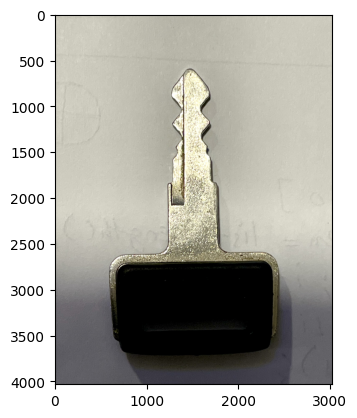

In [10]:
plt_img(key_images[0].rgb_img)

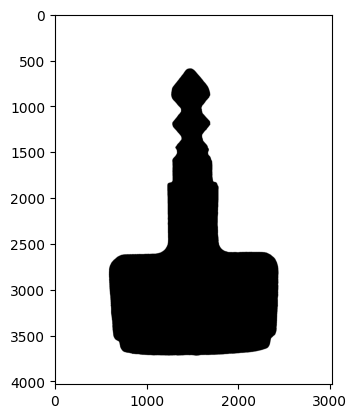

In [11]:
plt_img(key_images[0].mask_img, cmap='binary')

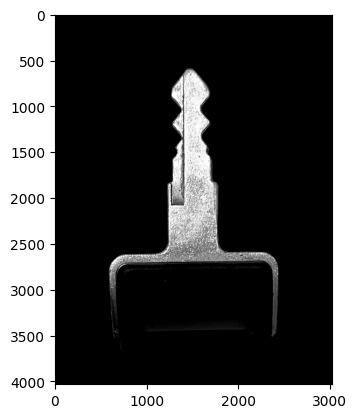

In [12]:
plt_img(key_images[0].cropped_feature, cmap='gray')

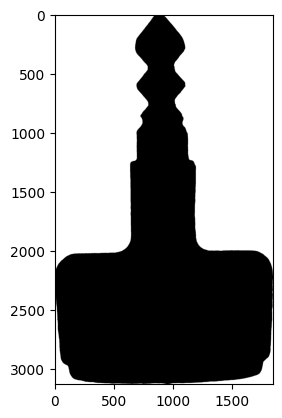

In [13]:
plt_img(key_images[0].cropped_mask, cmap='binary')

# Step 2: Transform Image (Rotation)

In [14]:
for image in key_images:
    masked_image = image.mask_img
    grayscae_image = image.cropped_feature

    # 1. Find contour of masked image
    contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 2. Fit an ellipse to the largest contour
    ellipse = cv2.fitEllipse(contours[0]) 

    # 3. Get ellipse properties
    center, axis_lengths, current_angle = ellipse

    # 4. Rotate image
    # Ellipse center is near to key holding area (if lower than key is facing upwards in image)
    is_below = is_ellipse_center_below_lower_half(center,masked_image.shape)
    rotation_angle = get_rotation_angle(is_below, current_angle)
    
    # 5. Fix grayscale and binary image size before applying rotation
    fixed_binary_image = fix_mask_image_size(masked_image)
    fixed_grayscale_image = fix_mask_image_size(grayscae_image)

    # 6. Apply rotation
    center = (fixed_binary_image.shape[1] // 2, fixed_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    
    rotated_binary_image = cv2.warpAffine(fixed_binary_image, rot_mat, fixed_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(fixed_grayscale_image, rot_mat, fixed_grayscale_image.shape[1::-1])
    
    # 7. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]
    
    # 8. Updated cropped masked
    image.cropped_mask = rotated_binary_image
    image.cropped_feature = rotated_grayscale_image

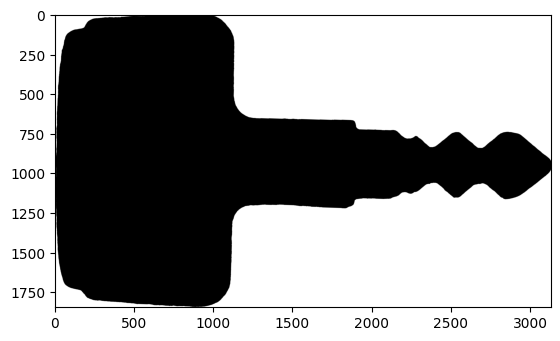

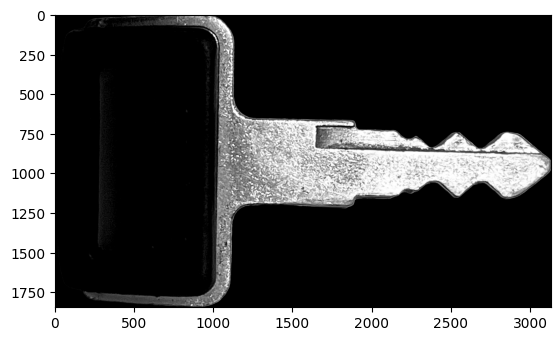

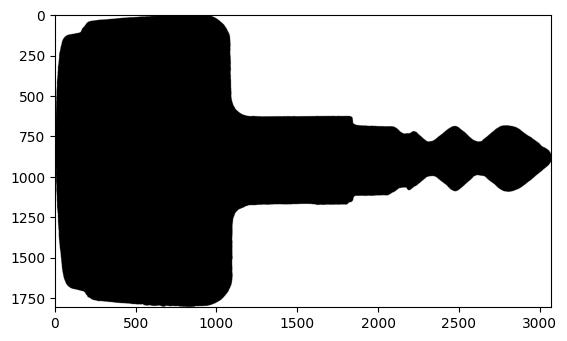

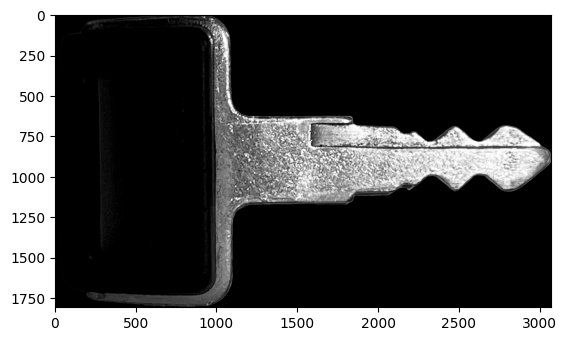

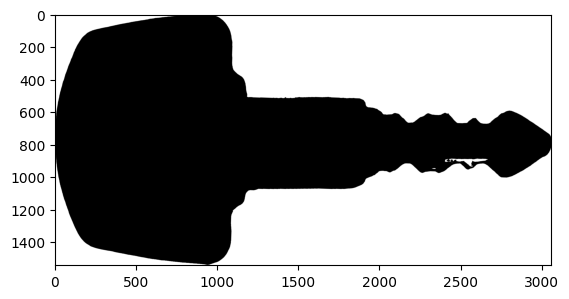

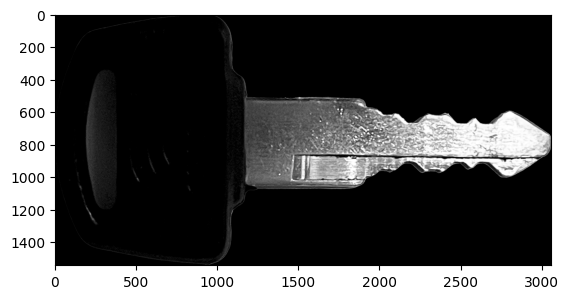

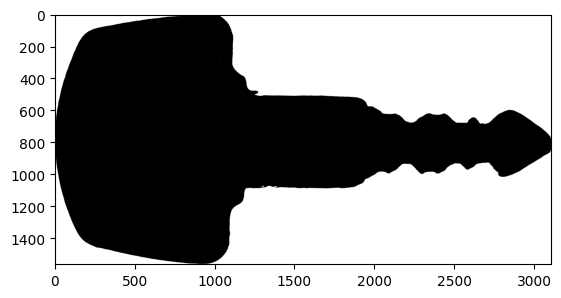

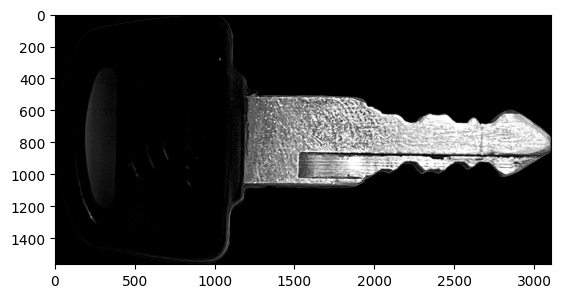

In [15]:
for img in key_images[:4]:
    plt_img(img.cropped_mask, cmap='binary')
    plt_img(img.cropped_feature, cmap='gray')

# Step 3: Resize / Standardise / Normalise keys to 512x512

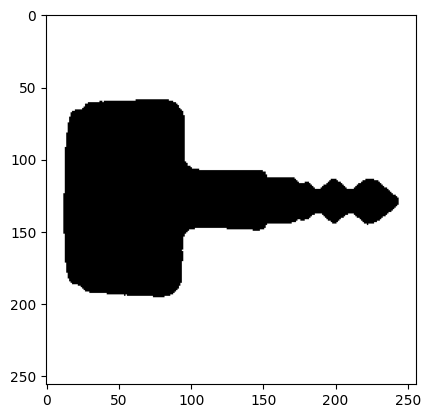

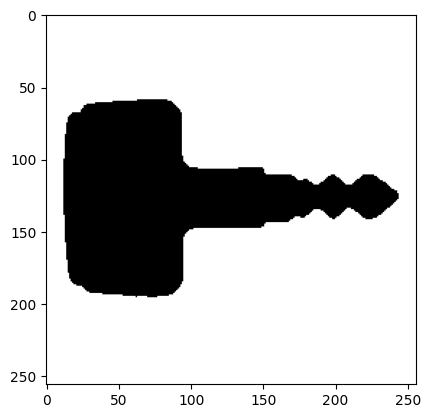

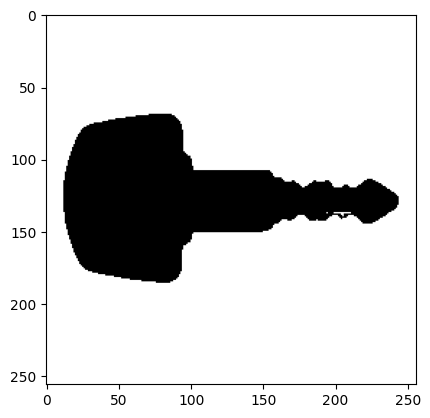

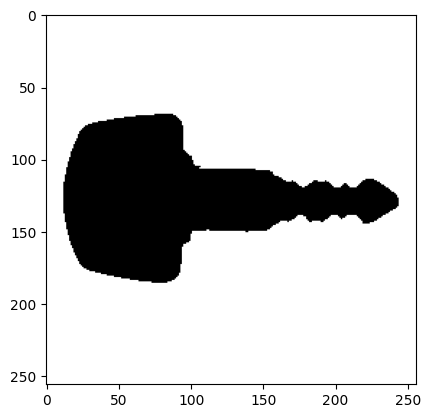

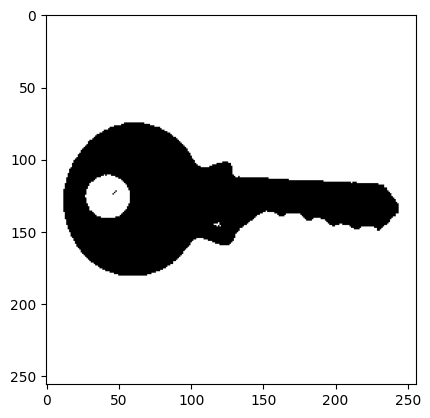

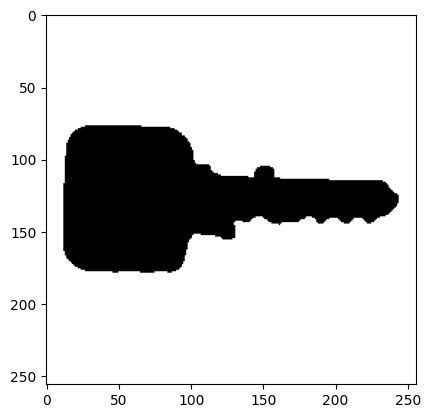

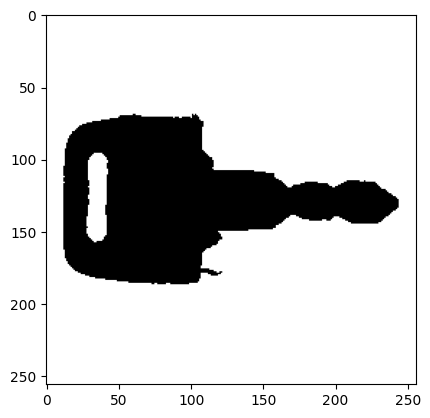

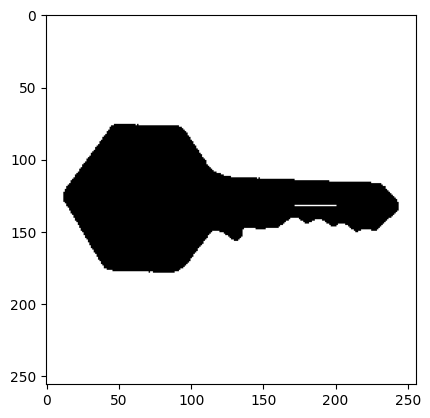

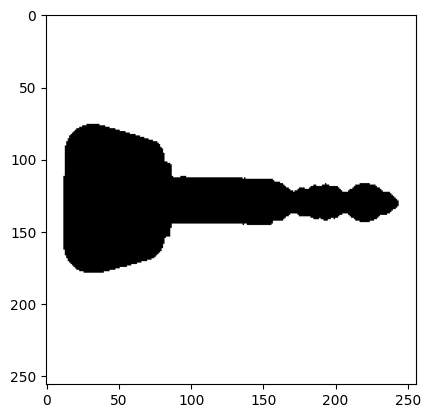

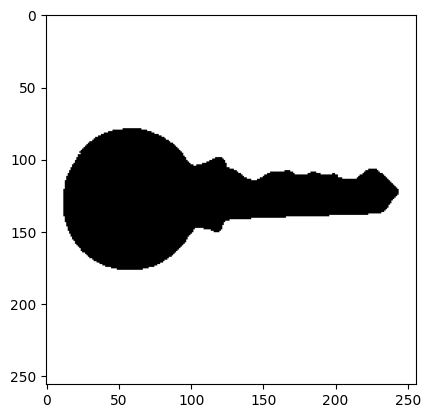

In [16]:
resized_binary_images = []

for image in key_images:
    resized_img = resize_binary_image_to_256x256(image.cropped_mask)
    resized_binary_images.append(resized_img)
    
for resized_img in resized_binary_images:
    plt_img(resized_img, cmap='binary')

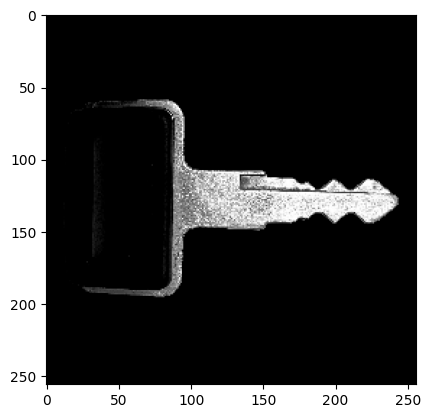

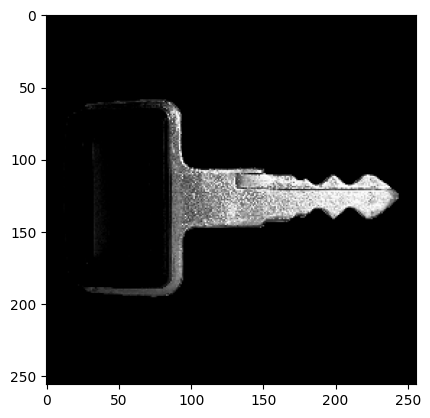

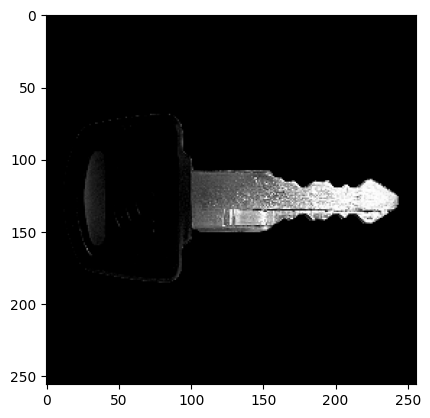

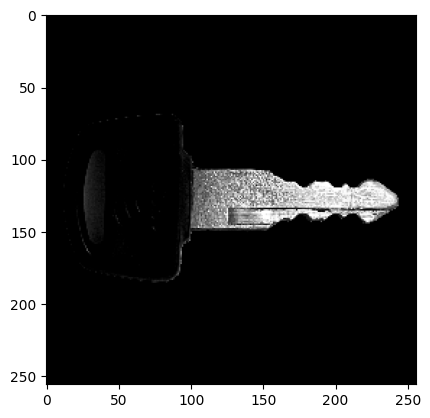

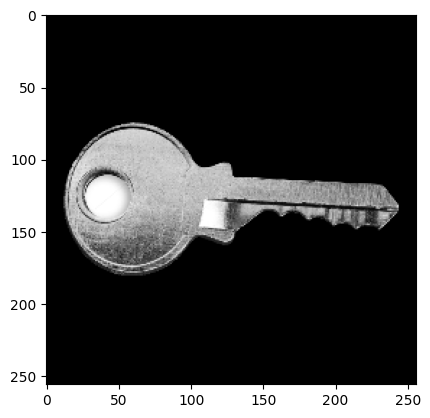

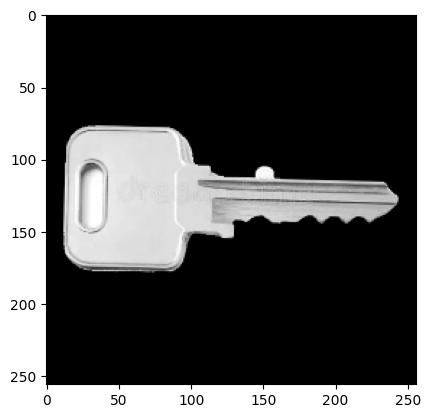

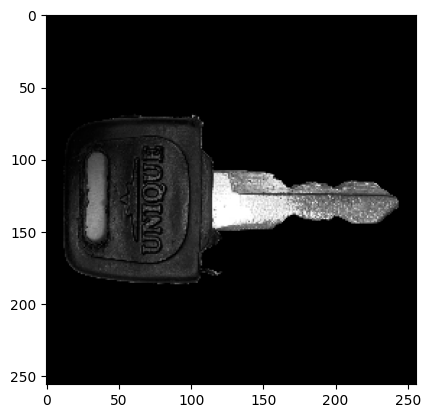

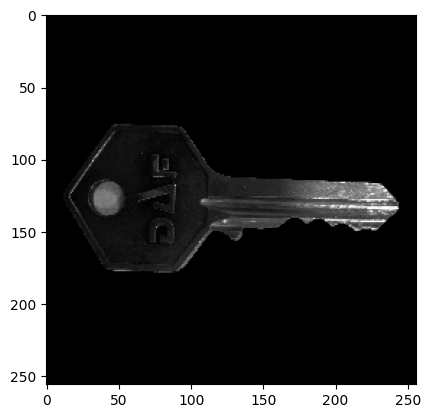

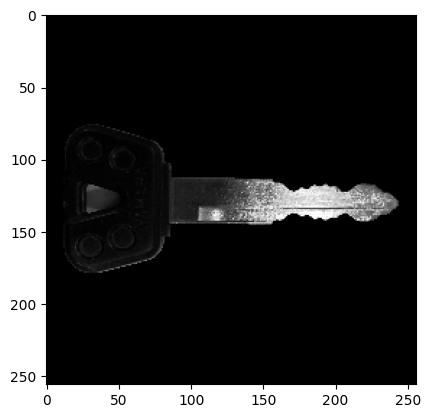

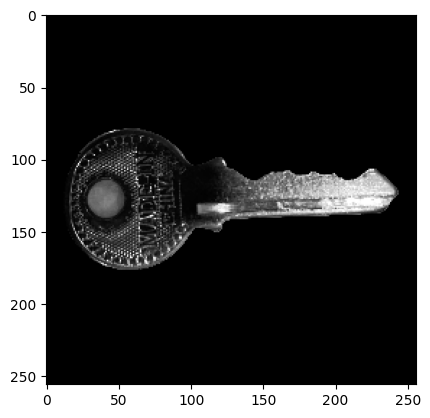

In [17]:
resized_grayscale_images = []

for image in key_images:
    resized_img = resize_grayscale_image_to_256x256(image.cropped_feature)
    resized_grayscale_images.append(resized_img)
    
for resized_img in resized_grayscale_images:
    plt_img(resized_img, cmap='gray')

In [18]:
# # Packed grayscale images bits
# resized_grayscale_packed_images = []

# for img in resized_grayscale_images:
#     packed_bits = pack_bits(img,num_bits=8)
#     resized_grayscale_packed_images.append(packed_bits)

In [19]:
# # Save this list into .csv file
# csv_file = 'features_grayscale_256x256.csv'

# # Write the list of flattened images to CSV
# with open(csv_file, 'w', newline='') as f:
#     writer = csv.writer(f)
#     for img in resized_grayscale_packed_images:
#         writer.writerow(packed_bits)

# Step 4: Store these extracted binary features to .csv

In [20]:
# Create empty list
flatten_images = []

# Loop images to apply bit packing
for resized_img in resized_binary_images:
    bit_packed_image = bit_packing(resized_img)
    flatten_image = bit_packed_image.flatten()
    flatten_images.append(flatten_image)
    
# Save this list into .csv file
csv_file = 'features_256x256.csv'

# Write the list of flattened images to CSV
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    for img in flatten_images:
        writer.writerow(list(img))

# Step 5: Read from .csv file to cross check save image

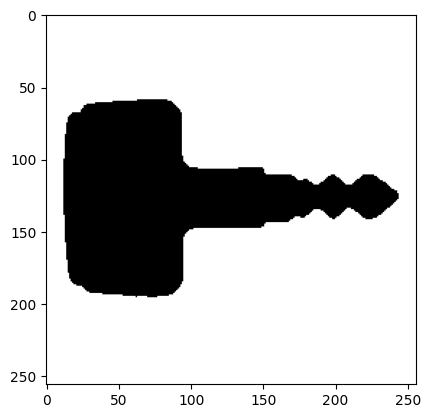

In [21]:
# Read dataframe
df = pd.read_csv('features_256x256.csv')

# Pick first row as sample and converty to uint8
test_img = (df.iloc[0].values).astype(np.uint8)

# Unpack bits to original dimensions
test_img = bit_unpacking(test_img, 256, 256)

# Plot test image
plt_img(test_img, cmap='binary')